## Objectives: 

    
    1. Generate a function that: 
        a. imports deepest point for each lake in the HydroLAKES dataset 
        b. crops dataset to Colorado boundary
        c. generates a 2km buffer around each deep point (proxy for lake catchment)
    2. Import MTBS data
        d. checks MTBS shapefile for overlap
        e. saves polygons from HydroLakes buffer region that overlap with MTBS dataframe to a geopandas df
            i. 'intersect' will produce a dataframe with just the overlapping areas among polygons. 
            ii. save whole MTBS fire polygons as second shapefile for later analysis
            iii. save whole burned lake perimeters as a third shapefile
    3. Import LimnoSat data from R generated .csv 
        a. subset LimnoSat data with 'Hylak_id' from burned lake perimeters
    4. Map data with folium to visualize burned lakes

Used with earth-analytics environment

# 1.  Import packages

In [1]:
import earthpy as et
import os
import os.path as op
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import ee
import geemap
import datatools
import pyproj
from shapely.geometry import Point # for making buffers around each point
# from shapely.geometry import Polygon #only needed if using lake polygons
from shapely.ops import transform
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches

from functools import partial
#from datetime import datetime
import matplotlib.pyplot as plt

# Am I still using these?
from functools import reduce #spatial overlay function

ee.Initialize()

import warnings
warnings.filterwarnings("ignore")

# 2. Set Directory

In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'cu_earthdata_certificate_2021', 'earthlab_project', 'data')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


### 3. Download and buffer lake data

###3a. Download the Colorado shapefile 
to use in clipping the MTBS and HydroLAKES dataset

In [3]:
url = 'https://opendata.arcgis.com/datasets/4402a8e032ed49eb8b37fd729e4e8f03_9.geojson'
colo_shp = gpd.read_file(url)

# Make sure appropriate crs for Colorado distances
colo_shp = colo_shp.set_crs(epsg=4326)

## 3b. Download lake .shps from HydroLAKES
Each entry of the HydroLAKES dataset can be matched to the LimnoSat dataset which provides lake median values for selected Landsat bands for all of the CONUS, via the Hylak_id column. HydroLAKES is the source of lake name and data, including lat-long values for each lake "deep point" as described by Topp et al. 2020. This dataset can be clipped to a Colorado shapefile, and then matched to LimnoSat so that only values that match both dataframes are saved. The GEE script in the link below also contains the lake pour points.

In [4]:
# Download HydroLAKES point data for Colorado

# LimnoSAT deepest points is a Google Earth Engine asset.  Clip to
# Colorado boundaries.

colorado = ee.FeatureCollection("TIGER/2018/States").filterMetadata("NAME", 'equals', 'Colorado')

dp = ee.FeatureCollection('users/eeProject/HydroLAKES_newct_NA_e5e5da51107417d472452564cef3eb4f').filterMetadata('type','equals','dp').filterMetadata('distance', "greater_than", 60).filterBounds(colorado)
hydro_points = geemap.ee_to_geopandas(dp, selectors=['Hylak_id'])
hydro_points.head()

hydro_points = hydro_points.to_crs(epsg=26953) # change to projected .crs for buffer calculation

In [5]:
# Checking the data format
hydro_points.head() # make sure that Hylak_id is an integer
print("Projection of dataframe: {}".format(hydro_points.crs))

Projection of dataframe: epsg:26953


## 3c.  Generate a 2km buffer around each deep point. 
This will be a proxy for the lake "catchment"

In [6]:
# Generate buffer
hydro_points['geometry']=hydro_points.geometry.buffer(2000)

Projection of dataframe: epsg:4326


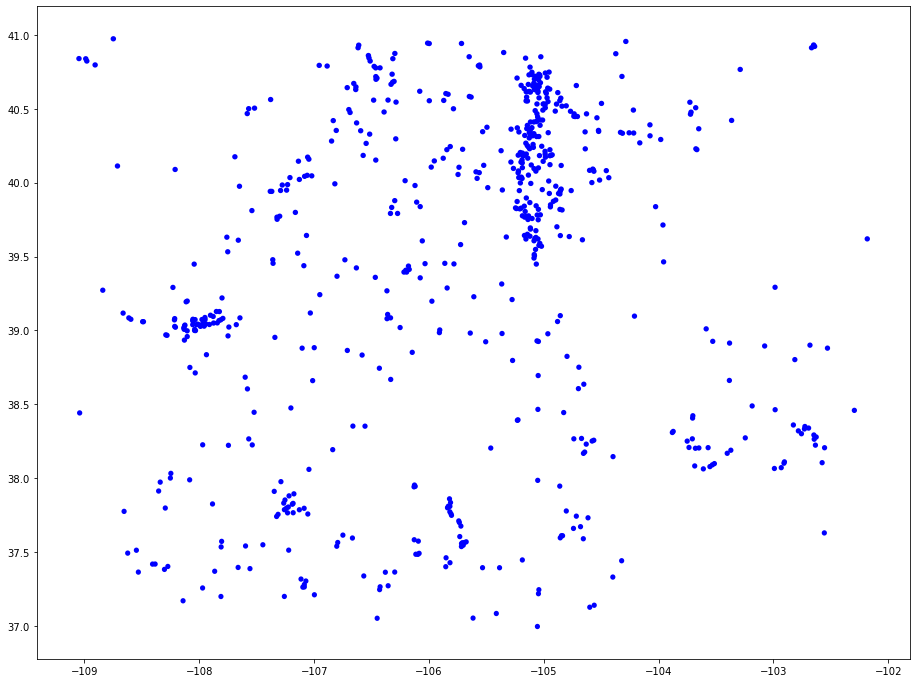

In [7]:
# Observe data
hydro_points.head()
hydro_points = hydro_points.to_crs(colo_shp.crs)
print("Projection of dataframe: {}".format(hydro_points.crs))

# Plot points 
fig, ax = plt.subplots(figsize=(16, 12))

hydro_points['geometry'].plot(ax=ax, 
                color='blue');



**NOT NECESSARY** For grins and visualization, import the HydroLakes shapefile that identifies lake polygons for Colorado

In [8]:
# Download HydroLAKES polygon data for Colorado
#url = 'https://97dc600d3ccc765f840c-d5a4231de41cd7a15e06ac00b0bcc552.ssl.cf5.rackcdn.com/HydroLAKES_polys_v10_shp.zip'
#hydro_polys = open_zips(url, colo_shp)

In [9]:
#hydro_polys.info()

In [10]:
# Export 
#out_path = os.path.join("data", "hydro_polys.shp")
#hydro_polys.to_file(out_path)

# 4. Download and merge fire data with lake dataset
### 4a. Download MTBS fire polygons within Colorado boundary

In [11]:
# Check to see if file is stored locally
file_path = os.path.join( "mtbs_polys.shp")
mtbs_polys =  gpd.read_file(file_path)

if not os.path.isfile(file_path):    
    url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip'
    mtbs_polys = datatools.open_zips(url, colo_shp)
    mtbs_polys.to_file(file_path)

In [12]:
mtbs_polys.head()

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CO3974110359220120625,None,LAST CHANCE,Wildfire,941,MTBS,Initial (SS),17958,39.78,-103.615,...,None,-9999,-9999,9999,9999,-100,-9999,-9999,None,"POLYGON ((-103.62033 39.86594, -103.62027 39.8..."
1,CO3943610521720120326,None,LOWER NORTH FORK FIRE,Wildfire,1301,MTBS,Extended,3436,39.45,-105.191,...,703303320120408,11,-9999,-970,-150,70,267,500,None,"POLYGON ((-105.19068 39.44712, -105.19085 39.4..."
2,CO3894510543620120617,None,SPRINGER,Wildfire,1302,MTBS,Extended,1665,38.947,-105.427,...,703303320120713,14,-9999,-970,-150,90,172,310,None,"POLYGON ((-105.42697 38.93460, -105.42804 38.9..."
3,CO3888410493320120623,None,WALDO CANYON,Wildfire,1304,MTBS,Extended,20112,38.928,-104.939,...,703303320120713,51,-9999,-970,-150,70,229,430,None,"POLYGON ((-104.98667 38.94346, -104.98666 38.9..."
4,CO3817710507320121023,None,WETMORE,Wildfire,1305,MTBS,Extended,2293,38.216,-105.065,...,None,23,-9999,-970,-150,150,286,480,None,"POLYGON ((-105.03434 38.20584, -105.03426 38.2..."


## 5b. Merge buffered lake dataset and MTBS fire dataset
Find burned lakes by merging datasets and identify overlaps with new set of polygons

In [13]:
# Merge fire and lake datasets
burnedlakes = gpd.overlay(hydro_points, mtbs_polys,  how ='intersection', keep_geom_type=False)

In [14]:
out_path = os.path.join("burnpolys.shp")
burnedlakes.to_file(out_path)

[None]

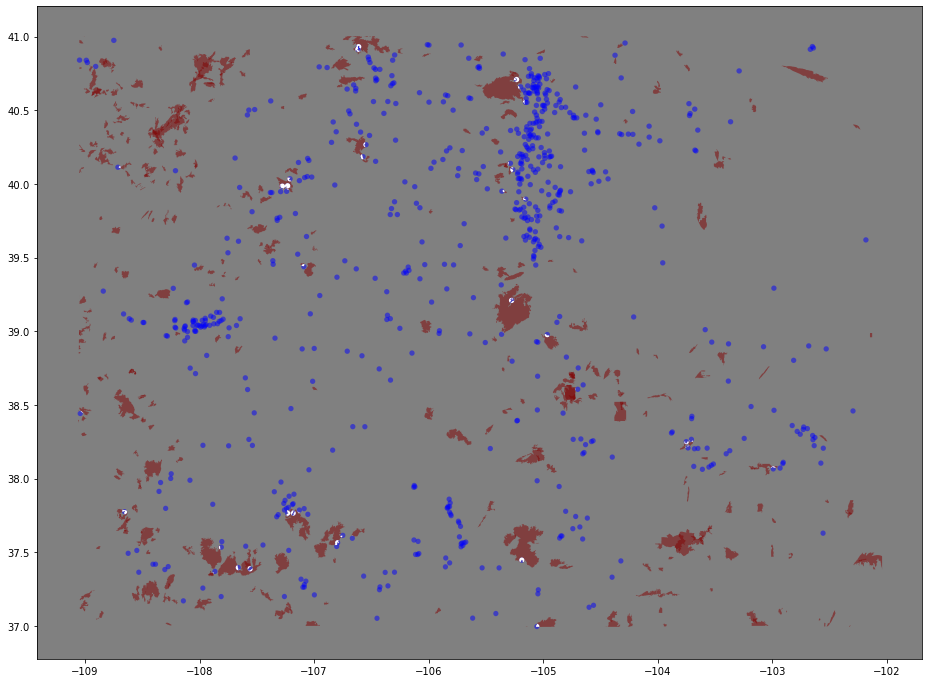

In [15]:
fig, ax = plt.subplots(figsize=(16, 12))

mtbs_polys['geometry'].plot(ax = ax, 
                     color='maroon',
                           alpha=0.5);

hydro_points['geometry'].plot(ax=ax, 
                color='blue', 
                alpha=0.5);

burnedlakes['geometry'].plot(ax=ax, color = 'white');

ax.set(facecolor = "grey")
#.set_axis_off()

## 5c. Export shapefiles

In [16]:
# To keep full burn perimeter for later classification, subset full MTBS
# dataset to include only fires that affected lakes in the merged datframe

subset_mtbs = mtbs_polys[mtbs_polys.set_index(['Event_ID']).index.isin(
    burnedlakes.set_index(['Event_ID']).index)]  # subset mtbs to fire ID found in burnedlakes

outfp = os.path.join("fire_perimeters.shp")
subset_mtbs.to_file(outfp)

# To keep full lake polygon for later classification, subset hydroLAKES deep points 
# dataset to include only fire affected lakes 

subset_lakes = hydro_points[hydro_points.set_index(['Hylak_id']).index.isin(
    burnedlakes.set_index(['Hylak_id']).index)]  # subset hydro points to lake name found in burnedlakes

outfp = os.path.join("whole_burned_lakes.shp")
subset_lakes.to_file(outfp)

In [17]:
# Create directory to store new image for blog
images_dir_path = op.join(op.dirname(op.abspath('')),'ea-2021-final-project-wildfire_lake_productivity', 'images')

# Check that is exists, and if it doesn't, create it
if not op.isdir(images_dir_path):
    os.mkdir(images_dir_path)

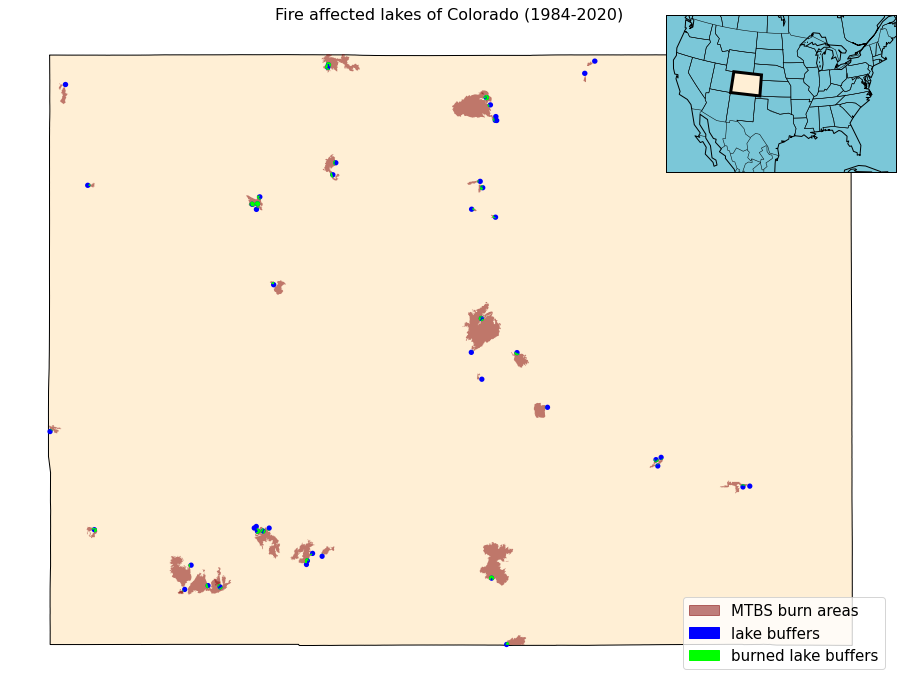

In [18]:
# Set asthetics for main (polys) map
fig, ax1 = plt.subplots(figsize=(16, 12))
plt.title("Fire affected lakes of Colorado (1984-2020)", fontsize = 16)
plt.axis('off')  # command for hiding the axis.
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

# Add a legend for polygons
red_patch = mpatches.Patch(color='maroon', alpha=0.5, label='MTBS burn areas')
blue_patch = mpatches.Patch(color='blue', label='lake buffers')
green_patch = mpatches.Patch(color='lime', label='burned lake buffers')

plt.legend(handles=[red_patch, blue_patch, green_patch], loc='lower right', fontsize = 15)

# These are in unitless percentages of the inset figure size. (0,0 is bottom left)
left, bottom, width, height = [0.7, 0.7, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

# Plot burned lakes in area of interest
colo_shp.plot(ax = ax1, 
                     color='papayawhip', edgecolors='black');
subset_mtbs['geometry'].plot(ax = ax1, 
                     color='maroon',
                            alpha=0.5);
subset_lakes['geometry'].plot(ax=ax1, 
                color='blue');
burnedlakes['geometry'].plot(ax=ax1, color = 'lime');

# Add the USA inset map
ax2 = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
ax2.drawmapboundary(fill_color='#7BC7D8')
ax2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
ax2.drawstates()
ax2.drawcoastlines()
ax2.drawcountries()

# Add area of interest polygon to inset map
x1,y1 = ax2(-102,37)
x2,y2 = ax2(-102,41)
x3,y3 = ax2(-109,41)
x4,y4 = ax2(-109,37)
poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='papayawhip',edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

plt.show()

In [19]:
# Save the image to the images directory for use in blog
fig.savefig(op.join(images_dir_path, 'burn_polys.png'),
            bbox_inches='tight', dpi=150)

### Checking in:
Now there should be 2 local shapefiles for later use:

    1. a shapefile containing whole burn perimeters
    2. a shapefile containing whole lake polygons (burned only)
    
   

# 6. Adding Landsat data
LimnoSAT a remote sensing dataset for inland waters from cloud-free Landsat observations of U.S. lakes larger than 0.1 km^2.  Reflectance values are extracted from the Chebyshev Center: the  center of the largest circle that can fit entirely within a given polygon's boundary(Topp et al. 2020, Shen et al. 2015) Topp et al. identify this point as the location of the pixel that is furthest away from the lake shoreline (derived from GEE script by Topp et al.) 

In [20]:
# Download LimnoSAT image data
# Check if file already exists before downloading it:

file_path = os.path.join("limnosat_pnts.feather")
limnosat = pd.read_feather(file_path)

if not os.path.isfile(file_path):    
    resp = requests.get(
        "https://zenodo.org/record/4139695/files/srCorrected_us_hydrolakes_dp_20200628.feather",
        stream=True)

    resp.raw.decode_content = True
    limn_fthr = io.BytesIO(resp.raw.read())
    limnosat = pd.read_feather(limn_fthr)    
    # Write out for future use if desired
    limnosat.to_file(file_path)

In [21]:
limnosat['Hylak_id'] = limnosat['Hylak_id'].astype(int)
limnosat = limnosat.set_index(['Hylak_id'])

In [22]:
limnosat['date'] = pd.to_datetime(limnosat['date'])
limnosat = limnosat.drop(['geometry', 'Country', 'Continent'], axis=1)

## 5a. Subset LimnoSat dataset 
LimnoSat CONUS to LimnoSat Colorado data by matching rows from Colorado 
deep lakes (hydro_points) to whole LimnoSat dataset, then merge the dataframes to generate
a LimnoSat dataset with burned lake deep points.

In [23]:
# Conversion of shared column to integer and index before merging (makes merge faster)
burnedlakes= burnedlakes.set_index(['Hylak_id'])

# Shorten limnosat to only lakes desired, makes merge faster
subset_limno = limnosat[limnosat.index.isin(
    burnedlakes.index)]  # subset LimnoSat to lake IDs found in CO HydroLAKES points

In [24]:
# Merge with `merge` method on shared variable (Hylak_id):
limnosat_pnts = subset_limno.merge(burnedlakes, on='Hylak_id')

In [25]:
# Export tabular data as .csv for faster use in data observations (ie. 02_observe_color_trends)
limnosat_pnts1 = limnosat_pnts.copy()
limnosat_pnts1 = limnosat_pnts1.drop(['geometry', 'geometry', 'Comment'], axis=1)
# Change category datatypes 
limnosat_pnts1['sat'] = limnosat_pnts1['sat'].astype(str)

# Export file to local drive
out_path = os.path.join("lake_mtbs_merged_tab.csv")
limnosat_pnts1.to_csv(out_path)

In [26]:
# Convert resulting dataframe to a geopandas dataframe

# Change category datatypes 
limnosat_pnts['sat'] = limnosat_pnts['sat'].astype(str)
limnosat_pnts['date'] = 'datetime'
# Change from dataframe to geodataframe by establishing geometry
limnosat_pnts = gpd.GeoDataFrame(limnosat_pnts, crs="EPSG:4326")
limnosat_pnts = limnosat_pnts.set_geometry("geometry")

# Export file to local drive
out_path = os.path.join("landsat_n_burnpolys.shp")
limnosat_pnts.to_file(out_path)


This is the third local shapefile containing partial lake polygons (portions that overlap with fire) along
with Landsat band values from LimnoSAT dataset